In [1]:
from timeit import default_timer as timer
import time
import numpy as np
import pandas as pd
from math import isnan
from sklearn import preprocessing
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from loguru import logger
import warnings
warnings.filterwarnings('ignore')

class PreProcessor:
   
    def __init__(self):
        self.unique_count = 1
        self.start_time=time.time()
    
    def RemoveIrrelevantColumn(self,df):
        #regex expressions for various formats of dates
        start_time=time.time()
        regex_patterns = [
        r'\b\d{4}-\d{2}-\d{2}\b',
        r'\b\d{2}[/-]\d{2}[/-]\d{4}\b',
        r'\b\d{2}[/-]\d{2}[/-]\d{4}\b',
        r'\b\d{4}/\d{2}/\d{2}\b',
        r'\b(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+\d{1,2},\s+\d{4}\b',
        r'\b\d{1,2}\s+(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+\d{4}\b',
        r'\b\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\b',
        r'\b\d{10,13}\b',
        r'\b(?:Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|Sunday),\s+(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+\d{1,2},\s+\d{4}\b',
        r'\b\d{1,2}(?:st|nd|rd|th)\s+(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+\d{4}\b'
        ]
        count=0
        for column in df.columns:
            if df[column].nunique(dropna=True)==self.unique_count:
                print(f'Column :{column} is removed')
                count=count+1
                df=df.drop(column,axis=1)
        print(f'{count} irrelavant columns found.')
        columns_to_remove = []
    
        for column in df.columns:
            # Check if any value in the column matches any regex pattern
            if any(df[column].astype(str).str.match(pattern).any() for pattern in regex_patterns):
                columns_to_remove.append(column)
        df = df.drop(columns=columns_to_remove)
        end_time=time.time()
        time_elp= end_time-start_time
        print(f'Execution time for RemoveIrrelevantColumn is {time_elp} seconds')
        
        return df

        

    def HandlingMissingData(self,df,num_strategy='most_frequent',cat_strategy='knn',n_neighbors=3,null_threshold=0.1):
        start_time=time.time()
        num_cols = df.select_dtypes(include=np.number).columns
        cat_cols = [column for column in df.columns if column not in num_cols]
        
        for column in num_cols:
            null_val=df[column].isnull().mean()
            if(null_val!=0 and null_val<=null_threshold):
                print(f'{null_val}% NaN values found on column: {column}')
                df=df.dropna(subset=[column])
                df= df.reset_index(drop=True)

        imputer=None
        if(num_strategy=='knn'):
            imputer = KNNImputer(n_neighbors=n_neighbors)
        else:
            if num_strategy in ['mean','median','mode','most_frequent']:
                imputer = SimpleImputer(strategy=num_strategy)
            else:
                print('Invalid imputer strategy specified :{}\nDefault strategy Mean is applied',num_strategy)
                imputer = SimpleImputer(strategy='mean')
        print('imputation process started...')
        for feature in num_cols:
            if df[feature].isna().sum().sum() != 0:
                try:
                    df_imputed = pd.DataFrame(imputer.fit_transform(np.array(df[feature]).reshape(-1, 1)))
                    if (df[feature].fillna(-9999) % 1  == 0).all():
                        df[feature] = df_imputed
                        # round back to INTs, if original data were INTs
                        df[feature] = df[feature].round()
                        df[feature] = df[feature].astype('Int64')                                        
                    else:
                        df[feature] = df_imputed
                except:
                    print('imputation failed for feature "{}"',feature)
        if(cat_strategy=='knn'):
            imputer = KNNImputer(n_neighbors=n_neighbors)
        elif(cat_strategy=='logreq'):
            df = PreProcessor.LogisticRegressionImputer(
                columns=cat_cols,
                df=df
            )
            return df
        else:
            imputer = SimpleImputer(strategy='most_frequent')
        
        for feature in cat_cols:
            if df[feature].isna().sum()!= 0:
                try:
                    mapping = dict()
                    mappings = {k: i for i, k in enumerate(df[feature].dropna().unique(), 0)}
                    mapping[feature] = mappings
                    df[feature] = df[feature].map(mapping[feature])

                    df_imputed = pd.DataFrame(imputer.fit_transform(np.array(df[feature]).reshape(-1, 1)), columns=[feature])    

                    # round to integers before mapping back to original values
                    df[feature] = df_imputed
                    df[feature] = df[feature].round()
                    df[feature] = df[feature].astype('Int64')  

                    # map values back to original
                    mappings_inv = {v: k for k, v in mapping[feature].items()}
                    df[feature] = df[feature].map(mappings_inv)
                except:
                    print('Imputation failed for feature "{}"',  feature)
        end_time=time.time()    
        time_elp= end_time-start_time
        print(f'Execution time for HandlingMissingData is {time_elp} seconds')
        return df
    
    
    def normalization(self,df):
        sc = StandardScaler()
        normalize_columns = []
        for column in df.columns:
            if (df[column].dtype == 'int64' or df[column].dtype == 'float64') and df[column].nunique() > 10:
                normalize_columns.append(column)
        df[normalize_columns] = sc.fit_transform(df[normalize_columns])
        # Is normalization Done well
        normalized_feature = df[normalize_columns]
        mean_normalized = np.mean(normalized_feature)
        std_dev_normalized = np.std(normalized_feature)
        print("Mean of normalized feature:", mean_normalized)
        print("Standard deviation of normalized feature:", std_dev_normalized)
        return df
    
    
    
    
    def encoding(self,df):   
        start_time=time.time()
        lable_encoder = preprocessing.LabelEncoder()
        object_columns = []
        for column in df.columns:
                if df[column].dtype == 'object' and df[column].nunique()<3: #binary 
                    df[column]=lable_encoder.fit_transform(df[column])
                    object_columns.append(column)
                elif df[column].dtype == 'object' and (df[column].nunique()>2): #Multi-class 
                    df[column]=lable_encoder.fit_transform(df[column])
                    object_columns.append(column)
                elif df[column].dtype == 'bool':
                    df[column]=lable_encoder.fit_transform(df[column])
                    object_columns.append(column)
                else:
                    pass
        
        end_time=time.time()
        time_elp= end_time-start_time
        print("Encoding process completed! It returns df and Object-col-list")
        print(f'Execution time for encoding is {time_elp} seconds') 
        total_time_elp= end_time-self.start_time
        print(f'Total Execution time for Preprocessing is {total_time_elp} seconds')     
        
        return df,object_columns,total_time_elp
    
    
    
        
    def LogisticRegressionImputer(self,columns,df):
             for feature in columns:
                 try:
                     test_df = df[df[feature].isnull()==True].dropna(subset=[x for x in df.columns if x != feature])
                     train_df = df[df[feature].isnull()==False].dropna(subset=[x for x in df.columns if x != feature])
                     if len(test_df.index) != 0:
                         pipe = make_pipeline(StandardScaler(), LogisticRegression())  
                         y = train_df[feature]
                         train_df.drop(feature, axis=1, inplace=True)
                         test_df.drop(feature, axis=1, inplace=True)   
                         model = pipe.fit(train_df, y)
                       
                         pred = model.predict(test_df) # predict values
                         test_df[feature]= pred
                         if (df[feature].fillna(-9999) % 1  == 0).all():
                             # round back to INTs, if original data were INTs
                             test_df[feature] = test_df[feature].round()
                             test_df[feature] = test_df[feature].astype('Int64')
                             df[feature].update(test_df[feature])                             
                         print('LOGREG imputation of {} value(s) succeeded for feature "{}"', len(pred), feature)
                 except:
                     print('LOGREG imputation failed for feature "{}"', feature)
                 for feature in df.columns: 
                     try:
                         # map categorical feature values back to original
                         mappings_inv = {v: k for k, v in mapping[feature].items()}
                         df[feature] = df[feature].map(mappings_inv)
                     except:
                         pass     
             return df
    

In [2]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
import statistics as stat
from imblearn.over_sampling import SMOTE


class Feature_Selection:
    def __init__(self):
        self.start_time=time.time()
        
        
    def constant_variance(self,data,threshold,dependent_variable):
        start_time=time.time()
        print("Finding Constant Variance...")
        x =data.drop(dependent_variable, axis=1)
        y=data[dependent_variable]
        
        constant_columns=[]
        
        var_thres=VarianceThreshold(threshold)
        var_thres.fit(x)
        
        constant_columns = [column for column in x.columns
                        if column not in x.columns[var_thres.get_support()]]
        
        # Printing the variance of the column
        
        for column in x:
         print(stat.variance(x[column]))
        print(f"No of Constant Columns are {len(constant_columns)}")
        
        print(f'{constant_columns} are being removed')
        
        
        # Dropping the constant Columns
        if constant_columns:
            x=x.drop(columns=constant_columns)
            print("Constant columns are successfully dropped.")
        else:
            print("No constant columns are found.")
            
        
        end_time=time.time()
        time_elp=end_time-start_time
        print(f"Time Elapsed for dropping constant variance: {time_elp} seconds")
        return data,x,y
    
    
    def k_select_best(self,x,y,threshold,mode):
        start_time=time.time()
        
        print("Selecting Best Features...\n")
        
        
        if mode=='classification':
            ordered_ranking_features =SelectKBest(score_func=f_classif, k='all')
            ordered_feature=ordered_ranking_features.fit(x,y) 
        elif mode=='regression':
            ordered_ranking_features =SelectKBest(score_func=f_regression, k='all')
            ordered_feature=ordered_ranking_features.fit(x,y)
        features_ranked=pd.DataFrame(ordered_feature.scores_,columns=['Score'])
        dfcolumns=pd.DataFrame(x.columns)
        features_rank=pd.concat([dfcolumns,features_ranked],axis=1)
        features_rank.columns=['Features','Score']
        features_rank_mod=features_rank[features_rank['Score']>=threshold]
        feature_names = features_rank_mod['Features'].values
        print("Features in rank order:")
        print(features_rank.sort_values(by='Score',ascending=False))
        print("\n\nSelected Features:")
        print(feature_names)
        x=x[feature_names]
        
        end_time=time.time()
        
        print("k_select_best is completed.")
        plt.bar(x=features_rank['Features'],height=features_rank['Score'])
        plt.show()
        time_elp=end_time-start_time
        print(f'\n\n Time taken to complete the k_select_best is:{time_elp}')
        return x
        
        
    
    def data_splitting(self,x,y):
        # smote = SMOTE()
        # x, y = smote.fit_resample(x, y)
        x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)
        return x_train,x_test,y_train,y_test
    
    
    def corr_drop(self,x,y):
        start_time=time.time()
        x_train,x_test,y_train,y_test=Feature_Selection.data_splitting(self,x,y)
        
        plt.figure(figsize=(12,10))
        cor = x_train.corr()
        sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
        plt.show()
        col_corr = set()  # Set of all the names of correlated columns
        corr_matrix = x_train.corr()
        for i in range(len(corr_matrix.columns)):
            for j in range(i): # lower triangle of an matrix
                if (corr_matrix.iloc[i, j]) > 0.95: # we are interested in coeff value
                    colname = corr_matrix.columns[i]  # getting the name of column
                    col_corr.add(colname)
        print(f'Total {len(col_corr)} are being removed and the Columns are: {col_corr}')
        print(x_train)
        x_train=x_train.drop(col_corr,axis=1)
        x_test=x_test.drop(col_corr,axis=1)
        print(x_train.columns)
        end_time=time.time()
        print(f"Time Elapsed for Correlation Drop: {end_time-start_time} seconds")
        
        

        return x_train,x_test,y_train,y_test
        
        
        

In [3]:
# from sklearn.feature_selection import VarianceThreshold
# from sklearn.model_selection import train_test_split
# import seaborn as sns
# import matplotlib.pyplot as plt 
# import pandas as pd
# from sklearn.feature_selection import chi2
# from sklearn.feature_selection import mutual_info_classif
# from sklearn.feature_selection import mutual_info_regression
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif
# from sklearn.feature_selection import f_regression
    


# class Feature_Selection:
#     def __init__(self,data,dependent_variable):
#         self.start_time=time.time()
#         self.unique_count = 1
#         print("Splitting of dataset into train and test...")
#         x = data.drop(dependent_variable, axis=1)
#         y = data[dependent_variable]
#         x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
#         self.x_train=x_train 
#         self.x_test = x_test
#         self.y_train = y_train
#         self.y_test = y_test   
#         self.dependent_variable = dependent_variable
        
#     def constant_variance(self,data):
#         start_time=time.time()
#         print("Finding Constant Variance Columns...")
#         constant_columns = []

#         var_thres=VarianceThreshold(threshold=0)
#         var_thres.fit(data)
#         constant_columns = [column for column in data.columns
#                         if column not in data.columns[var_thres.get_support()]]
#         print(len(constant_columns))
#         if constant_columns:
#          for column in constant_columns:
#              print(f'Total {len(constant_columns)} are being removed and the Columns are: {column}')
#          data=data.drop(columns=constant_columns)
#         else:
#             print("No constant variance columns found.")
#         end_time=time.time()
#         time_elp=end_time-start_time
#         print(f"Time Elapsed for dropping constant variance: {time_elp} seconds")
#         return data 
    
    
#     # def data_splitting(self,data, dependent_variable):
#     #     print("Splitting of dataset into train and test...")
#     #     # from sklearn.model_selection import train_test_split
        
#     #     x = data.drop(dependent_variable, axis=1)
#     #     y = data[dependent_variable]
#     #     # x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
#     #     # print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
#     #     # result_dict = {
#     #     #     'x_train': x_train,
#     #     #     'x_test': x_test,
#     #     #     'y_train': y_train,
#     #     #     'y_test': y_test
#     #     # }
         
    
#     #     return train_test_split(x, y, test_size=0.3, random_state=0)
    
    
    
#     def chi2(self,objects_columns):
#         start_time=time.time()
#         x_train =self.x_train
#         y_train=self.y_train
#         x_test =self.x_test
#         y_test = self.y_test
#         p_value=None
#         f_value=None
#         bool(objects_columns)
#         if objects_columns:
#             if objects_columns==self.dependent_variable:
#                 print(f"{len(objects_columns)} Categorial Variable Found.")
#                 objects_columns=objects_columns.remove(self.dependent_variable)
#                 x_train_objects = x_train[objects_columns]
#                 f_p_values = chi2(x_train_objects, y_train)
#                 p_value = pd.Series(f_p_values[1])
#                 f_value=pd.Series(f_p_values[0])
#                 p_value.index=x_train_objects.columns
#                 f_value.index=x_train_objects.columns
            
#         else:
#             print("No Categorial Variable found")
#         end_time=time.time()
#         time_elp=end_time-start_time
#         print(f"Time Elapsed for chi2 test: {time_elp} seconds")
#         return p_value,f_value,y_train,y_test



        
    
    
    
    
#     def corr_drop(self):
#         # x_train,x_test,y_train,y_test=Feature_Selection.data_splitting(data,dependent_variable)  # Data Splitting
#         start_time=time.time() 
#         x_train =self.x_train
#         x_test = self.x_test
        
#         #Using Pearson Correlation
#         plt.figure(figsize=(12,10))
#         cor = x_train.corr()
#         sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
#         plt.show()
#         col_corr = set()  # Set of all the names of correlated columns
#         corr_matrix = x_train.corr()
#         for i in range(len(corr_matrix.columns)):
#             for j in range(i): # lower triangle of an matrix
#                 if (corr_matrix.iloc[i, j]) > 0.90: # we are interested in coeff value
#                     colname = corr_matrix.columns[i]  # getting the name of column
#                     col_corr.add(colname)
#         print(f'Total {len(col_corr)} are being removed and the Columns are: {col_corr}')
#         print(x_train)
#         x_train=x_train.drop(col_corr,axis=1)
#         x_test=x_test.drop(col_corr,axis=1)
#         print(x_train.columns)
#         end_time=time.time()
#         print(f"Time Elapsed for Correlation Drop: {end_time-start_time} seconds")

#         return x_train,x_test
    
    
    
#     def select_kfeatures(self,type):
#         start_time=time.time()
#         x_train=self.x_train
#         y_train=self.y_train
#         x_test=self.x_test
#         if type=='classification':
#             ordered_rank_features=SelectKBest(score_func=f_classif,k='all')
#         elif type=='regression':
#             ordered_rank_features=SelectKBest(score_func=f_regression,k='all')
#         ordered_feature=ordered_rank_features.fit(x_train,y_train)
#         dfscores=pd.DataFrame(ordered_feature.scores_,columns=["Score"])
#         dfcolumns=pd.DataFrame(x_train.columns)
#         features_rank=pd.concat([dfcolumns,dfscores],axis=1)
#         features_rank.columns=['Features','Score']
#         features_rank_mod=features_rank[features_rank['Score']>=10]
#         feature_names = features_rank_mod['Features'].values
#         print(features_rank)
#         print(feature_names)
#         x_train=x_train[feature_names]
#         x_test=x_test[feature_names]
#         self.xtrain=x_train
#         self.xtest=x_test
#         plt.bar(x=features_rank['Features'],height=features_rank['Score'])
#         plt.show()
#         end_time=time.time()
#         print(f"Time Elapsed for Select K Features: {end_time-start_time} seconds")
#         tot_elp_time=self.start_time-end_time
#         print(f'Total Execution time for Feature Selection is {tot_elp_time} seconds')
#         return features_rank,x_train,tot_elp_time
    
    
#     def mutual_info(self):
#         x_train=self.xtrain
#         y_train=self.ytrain
#         x_test=self.xtest
#         print(x_train)
#         mi=mutual_info_classif(x_train,y_train )
#         filtered_features = x_train.columns[mi > 0.0]
#         x_train = x_train[filtered_features].loc[~(x_train[filtered_features] == 0.0).any(axis=1)]  # Omit rows with 0.001 values
#         x_test = x_test[filtered_features].loc[~(x_test[filtered_features] ==0.0).any(axis=1)]  # Omit rows with 0.001 values
#         self.xtrain=x_train
#         self.xtest=x_test
#         return x_train
    
#     def train_values(self):
#         return self.x_train,self.x_test,self.y_train,self.y_test
    
    
    
    
    

In [4]:
data=pd.read_csv('./kc_house_data.csv')
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [5]:
clean=PreProcessor()
data=clean.RemoveIrrelevantColumn(data)
data=clean.HandlingMissingData(data)
data,objects_columns,time1=clean.encoding(data)
data

0 irrelavant columns found.
Execution time for RemoveIrrelevantColumn is 4.1427321434021 seconds
imputation process started...
Execution time for HandlingMissingData is 0.005997896194458008 seconds
Encoding process completed! It returns df and Object-col-list
Execution time for encoding is 0.007154703140258789 seconds
Total Execution time for Preprocessing is 4.157019853591919 seconds


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,164,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,220,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,290,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,220,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,283,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,19,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,288,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,52,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,252,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [6]:
fs=Feature_Selection()
data,x,y=fs.constant_variance(data,0,'price')



Finding Constant Variance...
11991.051358959512
0.8650150097573506
0.5931512887356004
843533.6813681518
1715658774.1754704
0.2915880068770519
0.007485225502686409
0.5872426169774175
0.42346651239397143
1.381703289347649
685734.6672685076
195872.6684009628
862.7972621657613
161346.21186238268
2862.7878348128834
0.019199901796007925
0.01983262201789115
469761.23994532344
745518225.3404008
No of Constant Columns are 0
[] are being removed
No constant columns are found.
Time Elapsed for dropping constant variance: 0.23644232749938965 seconds


Selecting Best Features...

Features in rank order:
         Features         Score
3     sqft_living  21001.909641
9           grade  17360.635441
10     sqft_above  12514.060897
17  sqft_living15  11265.864580
2       bathrooms   8228.943228
7            view   4050.458981
11  sqft_basement   2531.506326
1        bedrooms   2270.655234
15            lat   2248.814652
6      waterfront   1650.463036
5          floors   1525.706143
13   yr_renovated    351.074838
4        sqft_lot    175.140305
18     sqft_lot15    147.906887
12       yr_built     63.229048
14        zipcode     61.344518
8       condition     28.611455
16           long     10.112071
0            date      0.467100


Selected Features:
['bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot' 'floors' 'waterfront'
 'view' 'grade' 'sqft_above' 'sqft_basement' 'yr_built' 'yr_renovated'
 'zipcode' 'lat' 'sqft_living15' 'sqft_lot15']
k_select_best is completed.


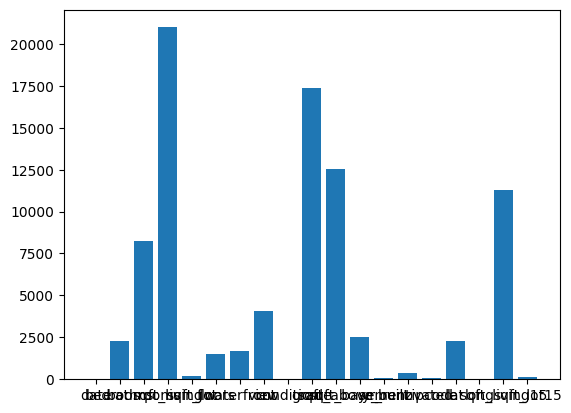



 Time taken to complete the k_select_best is:0.012190103530883789


In [7]:
x=fs.k_select_best(x,y,55,'regression')

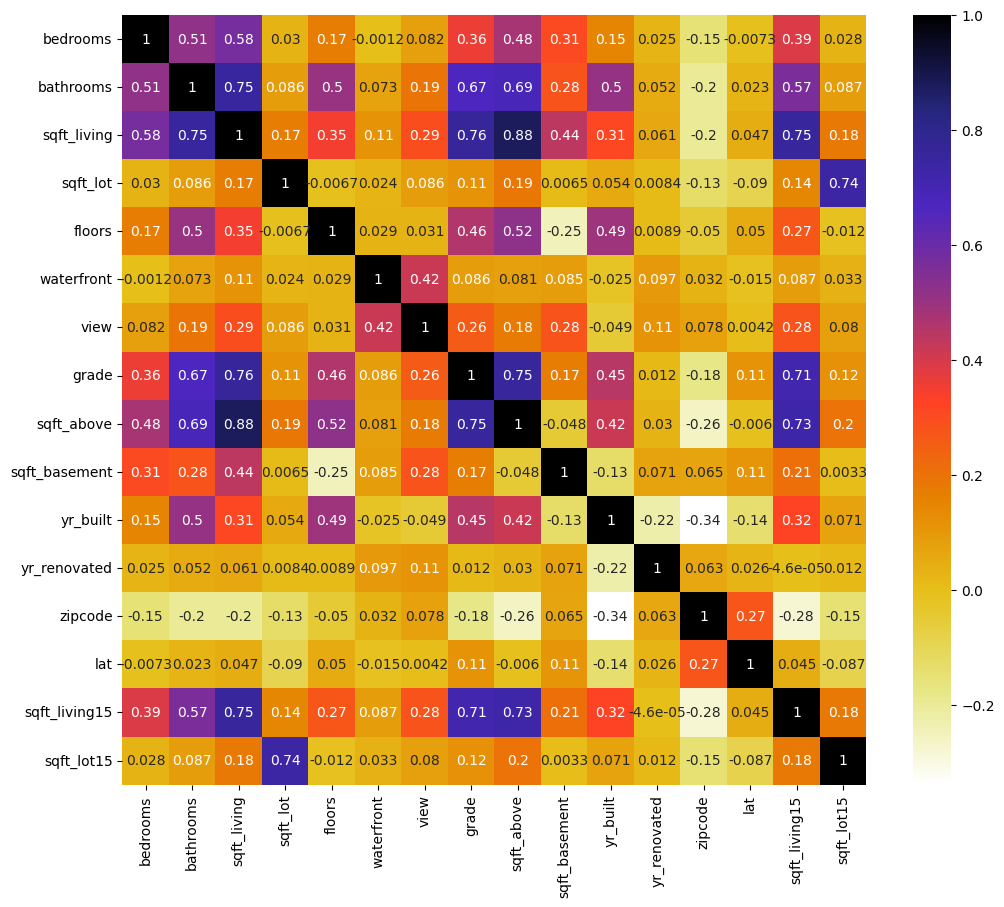

Total 0 are being removed and the Columns are: set()
       bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
1468          4       1.50         1390      7200     1.0           0     0   
15590         3       1.50         1450      7316     1.0           0     0   
18552         5       2.75         2860      5379     2.0           0     0   
10535         2       1.00         1050      4125     1.0           0     0   
1069          2       1.00         1240     57000     1.0           0     0   
...         ...        ...          ...       ...     ...         ...   ...   
13123         5       5.00         3960     94089     2.0           0     0   
19648         2       2.50         1400      1262     2.0           0     0   
9845          3       2.25         2360     14950     1.0           0     0   
10799         4       2.00         2370     76665     2.0           0     0   
2732          4       2.25         2380     16236     1.0           0     0   

In [8]:
x_train,x_test,y_train,y_test=fs.corr_drop(x,y)


In [9]:
from xgboost import XGBRegressor, plot_importance
xgb = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [10]:
start_time=time.time()
xgb.fit(x_train, y_train)
end_time=time.time()
elp_time=end_time-start_time
print(f"the training time is {elp_time}")

the training time is 0.2573513984680176


In [11]:
xgb.score(x_test,y_test)

0.875227155586718

In [12]:
# y_train_pred = model.predict(x_train)
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# mse = mean_squared_error(y_train, y_train_pred)
# mae = mean_absolute_error(y_train, y_train_pred)

# print("Mean Squared Error:", mse)
# print("Mean Absolute Error:", mae)

In [13]:
# Time Elapsed for Training for model for unprocessed data is 23.257768392562866 seconds
# Mean Squared Error: 15732978328.774221
# Mean Absolute Error: 66697.48322640346

# Without Feature Selection

In [14]:
data=pd.read_csv('./kc_house_data.csv')
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [15]:
from sklearn.preprocessing import LabelEncoder
start_time=time.time()
clean=PreProcessor()
# le=LabelEncoder()
data,objects_columns,t1=clean.encoding(data)
data=data.dropna()
end_time=time.time()
t1=end_time-start_time
print(f'Time Elapsed for Preprocessing with only dropping na and label encoding is {t1} seconds')
data

Encoding process completed! It returns df and Object-col-list
Execution time for encoding is 0.007700920104980469 seconds
Total Execution time for Preprocessing is 0.007700920104980469 seconds
Time Elapsed for Preprocessing with only dropping na and label encoding is 0.009114503860473633 seconds


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,164,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,220,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,290,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,220,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,283,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,19,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,288,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,52,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,252,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


Test Predict

In [16]:
from sklearn.ensemble import RandomForestClassifier

x=data.drop('price',axis=1)
y=data['price']
x_tr, x_t, y_tr, y_t = train_test_split(x, y, test_size=0.3, random_state=0)




from xgboost import XGBRegressor, plot_importance
xgb = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

# from sklearn.ensemble import RandomForestRegressor
# start_time=time.time()
# model = RandomForestRegressor(n_estimators=100, random_state=0)  # Adjust hyperparameters as needed
# model.fit(x_tr, y_tr)
# end_time=time.time()
# t2=end_time-start_time
# print(f'Time Elapsed for Training for model for unprocessed data is {t2} seconds')
# y_pred = model.predict(x_t)

# from sklearn.metrics import mean_squared_error, mean_absolute_error

# mse = mean_squared_error(y_t, y_pred)
# mae = mean_absolute_error(y_t, y_pred)

# print("Mean Squared Error:", mse)
# print("Mean Absolute Error:", mae)


# print(f"\n################# Total Time Taken is:###################\n{t1+t2}seconds")

In [17]:
start_time1=time.time()
xgb.fit(x_tr, y_tr)
end_time1=time.time()
elp_time1=end_time1-start_time1
print(f"the training time is {elp_time1}")

the training time is 0.2683889865875244


In [18]:
xgb.score(x_t,y_t)

0.8847459040492619

In [19]:
from sklearn.ensemble import RandomForestClassifier
import time
start_time=time.time()
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=0)  # Adjust hyperparameters as needed
model.fit(x_train, y_train)
end_time=time.time()
time3=end_time-start_time
print(f'Time Elapsed for Training for feature selected model is {time3} seconds')
y_pred = model.predict(x_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

# print(f"\n################# Total Time Taken is:###################\n{time1+time2+time3}seconds")

Time Elapsed for Training for feature selected model is 23.08470392227173 seconds
Mean Squared Error: 18646497603.268234
Mean Absolute Error: 72867.91530405615


Train Accuracy

In [ ]:
# y_tr_pred = model.predict(x_tr)
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# mse = mean_squared_error(y_tr, y_train_pred)
# mae = mean_absolute_error(y_tr, y_train_pred)

# print("Mean Squared Error:", mse)
# print("Mean Absolute Error:", mae)